In [43]:
import pandas as pd
import numpy as np
import sys
import os
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

#sys.path.append(os.path.abspath('../src'))

In [44]:

def TMensual(Tmort):
    """
    Interpola los valores de l(x) en pasos de 1/12 (mensual) y calcula q(x) y p(x).
    
    Parameters:
    Tmort (DataFrame): DataFrame que contiene las columnas 'x' y 'l(x)'.
    
    Returns:
    DataFrame: DataFrame con valores interpolados de x, l(x), q(x) y p(x).
    """
    
    # Aseguramos que Tmort tiene las columnas adecuadas
    if 'x' not in Tmort.columns or 'l(x)' not in Tmort.columns:
        raise ValueError("El DataFrame debe contener las columnas 'x' y 'l(x)'")
    
    # Obtener los valores de x y l(x)
    x_values = Tmort['x'].values
    lx_values = Tmort['l(x)'].values
    
    # Crear una función de interpolación
    interp_function = interp1d(x_values, lx_values, kind='linear', fill_value='extrapolate')
    
    # Crear los nuevos valores de x con un paso de 1/12, hasta 110 (incluyendo 110)
    new_x = np.arange(x_values[0], 110 + 1/12, 1/12)  # Incrementos mensuales hasta 110
    
    # Calcular los valores de l(x) interpolados
    new_lx = interp_function(new_x)
    
    # Inicializar los arrays para q(x) y p(x)
    qx_values = np.zeros(len(new_x) - 1)  # Inicializar el array para q(x)
    px_values = np.zeros(len(new_x) - 1)  # Inicializar el array para p(x)

    # Calcular q(x) y p(x) para cada nuevo valor de x
    for i in range(len(new_x)-1):
        if new_lx[i] > 0:  # Evitar división por cero
            qx_values[i] = 1 - (new_lx[i + 1] / new_lx[i])  # q(x) = 1 - l(x + 1/12) / l(x)
        else:
            qx_values[i] = 0  # Si l(x) es 0, q(x) también debe ser 0

        px_values[i] = 1 - qx_values[i]  # p(x) = 1 - q(x)


    # Crear un nuevo DataFrame con los valores interpolados y calculados
    interpolated_df = pd.DataFrame({
        'x': new_x,  # Incluir hasta 110
        'l(x)': new_lx,  # Excluir el último por la misma razón
        'q(x)': np.append(qx_values, 1),  # Añadir el valor de q(110)
        'p(x)': np.append(px_values, 0)  # Añadir el valor de p(110)
    })
    
    return interpolated_df

def tmort_filtered(df,edad):
    qx_vec=df[df['x']>=edad]
    return qx_vec

In [45]:

# Parámetros generales
n_personas = 1200
edad_jubilacion = 62
tasa_interes_mensual = 0.04 / 12  # Tasa mensual

# Cargar tablas de mortalidad
ruta_m = 'TM_mujeres.xlsx'
ruta_h = 'TM_hombres.xlsx'

Tmort_m = pd.read_excel(ruta_m)
Tmort_h = pd.read_excel(ruta_h)
data=pd.read_excel('datos_longevidad.xlsx',sheet_name="Data")


In [46]:
Tmort_m.head(15)
#Tmort_m['p(x)']=1-Tmort_m['q(x)']
#Tmort_h['p(x)']=1-Tmort_h['q(x)']
Tmort_h.head(15)
Tmort_m=(TMensual(Tmort_m))
Tmort_h=(TMensual(Tmort_h))

In [47]:
valoracion_jubilado=[]
valoracion_pareja=[]
i=0.04/12
for index, row in data.iterrows():
    genero=row['Genero']
    if genero=='H':
        tmort=Tmort_h
    else:
        tmort=Tmort_m
    if row['Casado']==0:

        #Renta Vitalicia
        edad= row['Edad']
        pago=row['Pago_mensual']
        T=tmort_filtered(tmort,edad)
        T['n'] = T['x'].apply(lambda x: x - edad)*12
        T['Vn'] = np.ones(len(T))*(1/(1+i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect=pago*T['Vn']*T['p(x)']
        va_jubilado=sum_vect.sum()
        va_pareja=0
        
        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)
        
    elif row['Casado']==1:
  
        #Renta vitalicia Reversible
        edad=row['Edad']
        pago=row['Pago_mensual']
        T=tmort_filtered(tmort,edad)
        T['n'] = T['x'].apply(lambda x: x - edad)*12
        T['Vn'] = np.ones(len(T))*(1/(1+i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect=pago*T['Vn']*T['p(x)']
        va_jubilado=sum_vect.sum()

        edad_pareja=row['Edad_pareja']
        genero_pareja=row['Sexo_pareja']
        if genero_pareja=='H':
            tmort_pareja=Tmort_h
        else:
            tmort_pareja=Tmort_m
            
        T_par=tmort_filtered(tmort_pareja,edad_pareja)
        T_par['n'] = T_par['x'].apply(lambda x: x - edad_pareja)*12
        T_par['Vn'] = np.ones(len(T_par))*(1/(1+i))
        T_par['Vn'] = T_par.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        
        if edad<=edad_pareja:
            T_par['q(x)_Jub'] = T['q(x)'][:len(T_par)]
        else:
            lista=[]
            gap=(edad-edad_pareja)*12
            lista = list(T['q(x)'])+list(np.ones(gap))
            T_par['q(x)_Jub']=lista
            
        sum_vect_pareja=pago*T_par['Vn']*T_par['p(x)']*T_par['q(x)_Jub']
        va_pareja=sum_vect_pareja.sum()
        
        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)

    
data['Valoracion Jubilado']=valoracion_jubilado
#data['Valoracion Jubilado']=data['Valoracion Jubilado'].apply(lambda x: x/1e3)
#data['Valoracion Jubilado']=data['Valoracion Jubilado'].apply(lambda x: f'{x:,.2f}')

data['Valoracion pareja']=valoracion_pareja
#data['Valoracion pareja']=data['Valoracion pareja'].apply(lambda x: x/1e3)
#data['Valoracion pareja']=data['Valoracion pareja'].apply(lambda x: f'{x:,.2f}')
data['Pago_mensual']=data['Pago_mensual'].apply(lambda x: f'{x:,.2f}')
data['Valoracion']=data['Valoracion Jubilado']+data['Valoracion pareja']

      

In [48]:
pd.set_option('display.float_format', '{:,.2f}'.format)
data.head(15)

,Unnamed: 0,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual,Valoracion Jubilado,Valoracion pareja,Valoracion
0,1,68,0,M,0,0,"4,196,583.06","1,017,456,036.16",0.00,"1,017,456,036.16"
1,2,67,1,H,67,H,"1,983,941.40","484,784,234.22","4,985,840.73","489,770,074.95"
2,3,80,1,H,77,H,"4,014,628.81","828,188,996.93","53,608,562.26","881,797,559.19"
3,4,71,1,H,85,M,"5,710,179.97","1,339,739,654.76","6,941,368.13","1,346,681,022.89"
4,5,66,0,M,0,0,"7,882,172.76","1,946,327,113.36",0.00,"1,946,327,113.36"
5,6,83,0,M,0,0,"4,168,962.19","812,238,687.55",0.00,"812,238,687.55"
6,7,79,1,M,75,H,"3,093,998.47","650,895,111.92","47,478,427.64","698,373,539.56"
7,8,81,1,M,77,M,"13,838,688.19","2,807,927,568.86","229,210,210.98","3,037,137,779.83"
8,9,75,0,M,0,0,"3,507,135.28","784,434,717.35",0.00,"784,434,717.35"
9,10,81,1,H,59,M,"5,767,559.72","1,167,876,389.39","333,842,385.10","1,501,718,774.50"


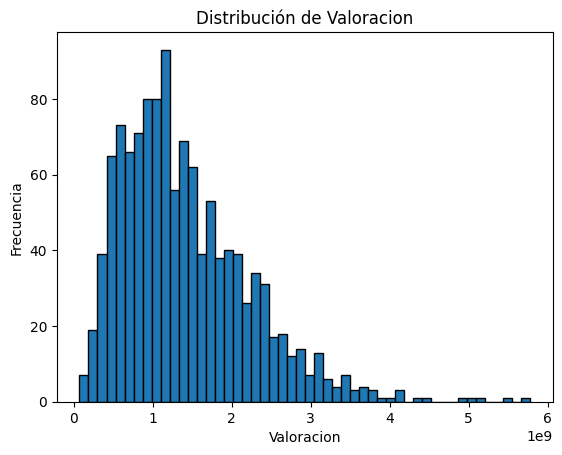

In [49]:
plt.hist(data['Valoracion'], bins=50, edgecolor='black')  # 'bins' ajusta el número de intervalos
plt.title('Distribución de Valoracion')
plt.xlabel('Valoracion')
plt.ylabel('Frecuencia')
plt.show()


In [50]:
#Ajustar la distribución gamma a los datos
shape, loc, scale = stats.gamma.fit(data['Valoracion'])

In [51]:
shape

2.865752561174397

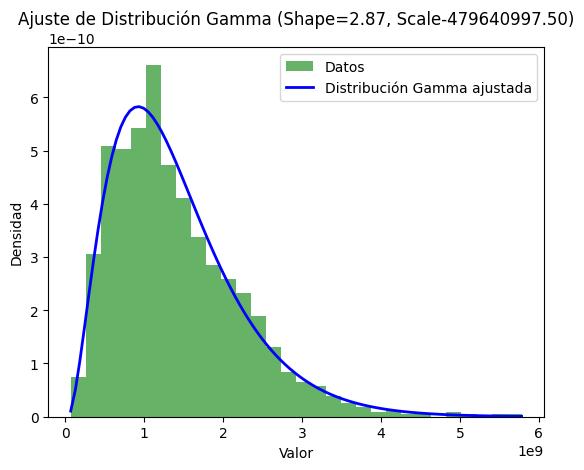

In [52]:
# Crear un rango de valores para La gráfica 
x = np.linspace(min (data['Valoracion']), max(data['Valoracion']), 100)

#Obtener La función de densidad ajustada usando Los parámetros obtenidos 
pdf_gamma_ajustada =stats.gamma.pdf(x, shape, loc, scale)

#Graficar el histograma de Los datos 
plt.hist(data['Valoracion'], bins= 30, density=True, alpha=0.6, color='g', label='Datos')

#Graficar la distribución gamma ajustada

plt.plot(x, pdf_gamma_ajustada, 'b-', linewidth=2, label='Distribución Gamma ajustada')

#Mostrar La gráfica
plt.title(f"Ajuste de Distribución Gamma (Shape={shape:.2f}, Scale-{scale:.2f})")
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.legend()
plt.show()

In [53]:
#el intervalo de confianza de la distribucion al 5%
shape = 2.87 # Nuevo parámetro de forma
scale = 479640997 # Nuevo parámetro de escala
quantile_5 = stats.gamma.ppf(0.05, a=shape, scale=scale) #Percent point function
quantile_95 = stats. gamma.ppf(0.95, a=shape, scale=scale)
print(f"Cuantil al 5%: {quantile_5}")
print(f"Cuantil al 95%: {quantile_95}")

Cuantil al 5%: 360576647.60582757
Cuantil al 95%: 2926050013.444586


In [54]:
#calcule el valor del objetivo corporativo, si este es reducir el compromiso total por pensiones en al
Total=data['Valoracion'].sum()
objetivo=Total*0.3
print('El objetivo del bànco es reducir su compromiso por pensiones en al menos: ', objetivo)

El objetivo del bànco es reducir su compromiso por pensiones en al menos:  506252650354.34235


In [55]:
Total

1687508834514.4746

In [56]:
data['Propuesta']=data['Valoracion']*0.7
Total_propuesta=data['Propuesta'].sum()
data.head(5)

,Unnamed: 0,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual,Valoracion Jubilado,Valoracion pareja,Valoracion,Propuesta
0,1,68,0,M,0,0,"4,196,583.06","1,017,456,036.16",0.00,"1,017,456,036.16","712,219,225.31"
1,2,67,1,H,67,H,"1,983,941.40","484,784,234.22","4,985,840.73","489,770,074.95","342,839,052.47"
2,3,80,1,H,77,H,"4,014,628.81","828,188,996.93","53,608,562.26","881,797,559.19","617,258,291.44"
3,4,71,1,H,85,M,"5,710,179.97","1,339,739,654.76","6,941,368.13","1,346,681,022.89","942,676,716.02"
4,5,66,0,M,0,0,"7,882,172.76","1,946,327,113.36",0.00,"1,946,327,113.36","1,362,428,979.36"


In [57]:
# Crear el Data Frame 
data_sim = pd.DataFrame()
data_sim['key'] = list(data.index)
data_sim['Valoracion'] = list(data.Valoracion)

# Le daremos a cada persona el 70% del valor de la renta
d = 0.7
data_sim['Pago_hoy'] = (d) * data_sim['Valoracion']

sim = 500
p = 0.17 #valor de aceptación mínimo

for i in range(500):  # Genera 500 simulaciones
    # Genera las muestras de la distribución Binomial
    samples = np.random.binomial(1, p, len(data_sim))  # b(n,p,size)
    
    # Crea la nueva columna para la simulación
    data_sim['sim_' + str(i)] = samples

    # Aplica la lógica a cada fila:
    # Si el valor de la simulación es 1, toma 'Pago_hoy'; si es 0, toma 'Valoracion'
    data_sim['sim_' + str(i)] = data_sim.apply(
        lambda row: row['Pago_hoy'] if row['sim_' + str(i)] == 1 else row['Valoracion'], axis=1
    )


In [58]:
data_sim

,key,Valoracion,Pago_hoy,sim_0,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,...,sim_490,sim_491,sim_492,sim_493,sim_494,sim_495,sim_496,sim_497,sim_498,sim_499
0,0,"1,017,456,036.16","712,219,225.31","1,017,456,036.16","712,219,225.31","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","712,219,225.31",...,"1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","712,219,225.31","712,219,225.31","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16"
1,1,"489,770,074.95","342,839,052.47","489,770,074.95","489,770,074.95","342,839,052.47","489,770,074.95","489,770,074.95","489,770,074.95","489,770,074.95",...,"342,839,052.47","342,839,052.47","489,770,074.95","489,770,074.95","489,770,074.95","342,839,052.47","489,770,074.95","489,770,074.95","489,770,074.95","342,839,052.47"
2,2,"881,797,559.19","617,258,291.44","881,797,559.19","881,797,559.19","881,797,559.19","881,797,559.19","881,797,559.19","881,797,559.19","881,797,559.19",...,"881,797,559.19","881,797,559.19","617,258,291.44","881,797,559.19","881,797,559.19","881,797,559.19","881,797,559.19","881,797,559.19","617,258,291.44","881,797,559.19"
3,3,"1,346,681,022.89","942,676,716.02","1,346,681,022.89","1,346,681,022.89","1,346,681,022.89","942,676,716.02","1,346,681,022.89","942,676,716.02","942,676,716.02",...,"1,346,681,022.89","1,346,681,022.89","942,676,716.02","1,346,681,022.89","1,346,681,022.89","942,676,716.02","1,346,681,022.89","1,346,681,022.89","1,346,681,022.89","1,346,681,022.89"
4,4,"1,946,327,113.36","1,362,428,979.36","1,362,428,979.36","1,946,327,113.36","1,946,327,113.36","1,946,327,113.36","1,946,327,113.36","1,362,428,979.36","1,946,327,113.36",...,"1,946,327,113.36","1,946,327,113.36","1,946,327,113.36","1,946,327,113.36","1,362,428,979.36","1,946,327,113.36","1,362,428,979.36","1,362,428,979.36","1,946,327,113.36","1,946,327,113.36"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,"640,482,469.74","448,337,728.82","448,337,728.82","448,337,728.82","640,482,469.74","640,482,469.74","640,482,469.74","448,337,728.82","640,482,469.74",...,"640,482,469.74","448,337,728.82","640,482,469.74","448,337,728.82","448,337,728.82","640,482,469.74","640,482,469.74","640,482,469.74","640,482,469.74","640,482,469.74"
1196,1196,"913,985,755.27","639,790,028.69","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27","639,790,028.69",...,"913,985,755.27","913,985,755.27","913,985,755.27","639,790,028.69","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27"
1197,1197,"846,745,509.27","592,721,856.49","846,745,509.27","846,745,509.27","846,745,509.27","846,745,509.27","846,745,509.27","846,745,509.27","846,745,509.27",...,"846,745,509.27","592,721,856.49","846,745,509.27","846,745,509.27","846,745,509.27","592,721,856.49","846,745,509.27","846,745,509.27","846,745,509.27","846,745,509.27"
1198,1198,"2,348,062,669.86","1,643,643,868.90","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","1,643,643,868.90","2,348,062,669.86","2,348,062,669.86",...,"2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","1,643,643,868.90","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86"


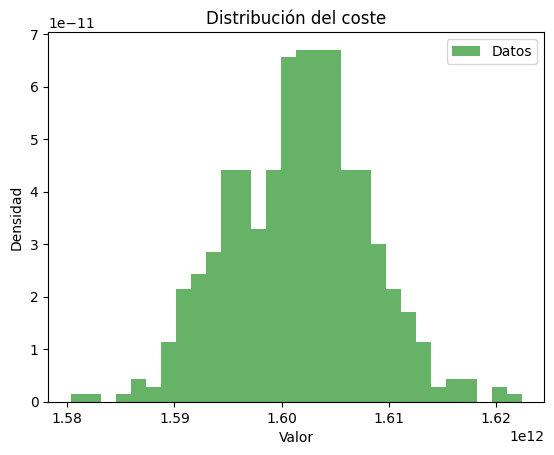

75758852858.62256

In [60]:
#Ahorro_final al 95% de confianza
cols=[col for col in data_sim.columns if 'sim' in col]
resp=data_sim[cols].sum()
# Graficar el histograma de los datos
plt.hist(resp, bins=30, density=True, alpha=0.6, color='g', label='Datos')
# Mostrar la gráfica
plt.title(f"Distribución del coste")
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.legend()
plt.show()
cuantil_95 = np.percentile(resp, 95)
ahorro=Total-cuantil_95
ahorro

In [61]:
cuantil_95

1611749981655.852

In [62]:
resp

sim_0     1,600,117,644,267.26
sim_1     1,609,655,852,698.52
sim_2     1,606,646,635,571.94
sim_3     1,613,499,116,639.30
sim_4     1,603,039,847,264.30
                  ...         
sim_495   1,607,013,326,358.85
sim_496   1,604,603,023,740.46
sim_497   1,590,030,329,875.79
sim_498   1,617,258,923,820.88
sim_499   1,599,589,821,712.63
Length: 500, dtype: float64

In [63]:
ahorro

75758852858.62256

In [64]:
cuantil_95

1611749981655.852

In [65]:
objetivo

506252650354.34235

In [66]:
Total

1687508834514.4746

In [67]:
1200*0.2

240.0

In [68]:
ahorro >= objetivo

False